## 1. 데이터 전처리 및 모델 정의

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [14]:
# 이미지 전처리를 위한 변환(transform) 설정

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# FashionMNIST 데이터셋 다운로드 및 로드

# 학습 데이터
trainset = torchvision.datasets.FashionMNIST('./data',
                                             download=True,
                                             train=True,
                                             transform=transform)

# 테스트 데이터
testset = torchvision.datasets.FashionMNIST('./data',
                                            download=True,
                                            train=False,
                                            transform=transform)

# 데이터 로더 설정

# 학습 데이터 로더
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# 테스트 데이터 로더
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# FashionMNIST의 클래스(레이블) 정보
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [15]:
# 이미지를 출력하기 위한 도우미 함수

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 # 정규화 해제
    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))

In [16]:
# 신경망 모델 정의

class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16*4*4)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# 모델 인스턴스 생성
net = Net()

In [17]:
# 손실 함수 및 최적화기 설정

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)

## 2. TensorBoard 설정 및 초기 시각화

In [18]:
# TensorBoard 로그 디렉토리 설정

writer = SummaryWriter('app/fasion_mnist_experiment_1')

In [19]:
# TensorBoard 확장 로드

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
# TensorBoard 실행

%tensorboard --logdir "app"

Reusing TensorBoard on port 6007 (pid 81380), started 0:25:00 ago. (Use '!kill 81380' to kill it.)

In [31]:
# 캐시 생겼을 경우 종료하고 다시 실행

!tensorboard --logdir logs --port 6006 --reload_interval

TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--de

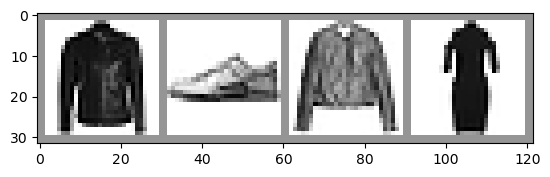

In [22]:
# 무작위 학습 이미지 몇 개 선택

dataiter = iter(trainloader)
images, labels = next(iter(dataiter))

# 이미지 그리드 생성

img_grid = torchvision.utils.make_grid(images)

# 이미지 출력

matplotlib_imshow(img_grid, one_channel=True)

# TensorBoard에 이미지 기록

writer.add_image('four_fasion_mnist_images', img_grid)


In [23]:
# TensorBoard에 모델 그래프 추가

writer.add_graph(net, images)
writer.close()

In [27]:
# 데이터셋에서 n개의 무작위 데이터와 레이블을 선택

def select_n_random(data, labels, n=100):
    # n개의 무작위 데이터와 해당 레이블을 데이터셋에서 선택

    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# 무작위 이미지와 해당 인덱스 선택
images, labels = select_n_random(trainset.data, trainset.targets)

# 각 이미지의 클래스 레이블 가져오기
class_labels = [classes[lab] for lab in labels]

# 임베딩 로그
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))

writer.close()

In [28]:
# 예측 및 확률 생성 도우미 함수

def images_to_probs(net, images):
    # 학습된 네트워크와 이미지 목록을 사용하여 예측 및 해당 확률 생성

    output = net(images)
    _, preds_tensor = torch.max(output,1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

# 예측과 확률을 시각화하는 함수

def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net,images)
    fig = plt.figure(figsize=(12,48))

    for idx in np.arange(4):
        ax = fig.add_subplot(1,4,idx+1, xticks=[], yticks =[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## 3. 모델 학습

In [29]:
# 학습 시작

running_loss = 0.0

for epoch in range(2) : # 데이터셋을 여러 번 반복
    for i,data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 1000 == 999: # 1000 미니 배치마다
            writer.add_scalar('training loss',
                              running_loss / 1000,
                              epoch * len(trainloader) + i)
            writer.add_figure('predictions vs, actuals',
                              plot_classes_preds(net, inputs, labels),
                              global_step=epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

Finished Training


## 4. 테스트 데이터 예측 및 분석

In [30]:
# 테스트 데이터에서 확률 및 예측 가져오기

class_probs = []
class_label = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# 정밀도-재현율 곡선을 TensorBoard에 추가하는 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율 곡선 그리기
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)    
